# Sequence Analysis

## I. Setup

### I.1 Load Libraries
First we have to load a few libraries:


In [1]:
install.packages("TraMineR", dependencies=TRUE, repos = "http://cran.us.r-project.org")

library(TraMineR)
library(RColorBrewer)
library(cluster)


The downloaded binary packages are in
	/var/folders/s0/cpch1n253877slkrcpdzqgph0000gn/T//RtmpmQHS76/downloaded_packages



TraMineR stable version 1.8-12 (Built: 2016-06-25)
Website: http://traminer.unige.ch
Please type 'citation("TraMineR")' for citation information.



### I.2 Load
Afterwards we have to load the data using:

In [2]:
rawData = read.csv("Pedro_Review_22062015.csv",sep=";") 

Note that this is the very same file you sent me. I just saved it in `.csv`

The following code separates the rows of each dimension in separate variables:

In [3]:
companies = rawData[rawData[,5]=="Companies",]
titles = rawData[rawData[,5]=="Titles",]
membership = rawData[rawData[,5]=="Board Memberships",]

### I.3 Auxiliar Functions
Also, we'll define a few auxiliar functions. 

Right now the variables ``companies``, ``titles`` and ``membership`` are matrices containing all data. The function ``getSequence`` cuts the qualitative data and leaves only the sequence part of the matrices.

The ``trim`` function cleans the strings in the data. Probably due to errors during coding some of the data is for example "A " instead of "A", and the function ``trim`` removes those spaces

The last function, called ``makeSequencePlots``, just creates the 4 basic plots we look at. Just so I don't have to rewrite it everytime.


In [4]:
getSequence <- function(raw){
  return(raw[,-seq(1:5)])
}



trim <- function (x) gsub("^\\s+|\\s+$", "", x)
    
    
    
makeSequencePlots <- function(seq){
  seqIplot(seq,sortv="from.start",withlegend=TRUE,title="Companies - All sequences - Sort by start")
  
  seqIplot(seq,sortv="from.end",withlegend=TRUE,title="Companies - All sequences - Sort by end")
  
  seqfplot(seq, withlegend = TRUE, border = NA, title="10 Most Frequent Sequences")
  
  seqdplot(seq, withlegend = TRUE, border = NA, title="States Distribution Over Time")
  
  seqmtplot(seq, withlegend = TRUE, title="Mean Time spent in each State")
  return(TRUE)
}    


## II. Cleaning the data

First step is to create a sequence-only matrix. Afterwards we make sure all the letters are in upper case and remove some data that seems to be wrongly coded. It might be worth a double check on your end. These are:

* Partner
* Consultant
* President
* President, COO,CEO
* Senior Advisor
* sr. v.p., corp. Strategy
* President, COO
* CHECK

I just put ``Z`` on all of them.

Lastly, the ``for`` loops just trim all the strings in the sequences.

In [5]:

companiesSequence <- getSequence(companies)

companiesSequence[companiesSequence == "b"] <- "B"
companiesSequence[companiesSequence == "c"] <- "C"
companiesSequence[companiesSequence == "Partner"] <- "Z"
companiesSequence[companiesSequence == "Consultant"] <- "Z"
companiesSequence[companiesSequence == "President"] <- "Z"
companiesSequence[companiesSequence == "President, COO,CEO"] <- "Z"
companiesSequence[companiesSequence == "Senior Advisor"] <- "Z"
companiesSequence[companiesSequence == "sr. v.p., corp. Strategy"] <- "Z"
companiesSequence[companiesSequence == "President, COO"] <- "Z"
companiesSequence[companiesSequence == "CHECK"] <- "Z"

for (row in seq(1:dim(companiesSequence)[1])){
  for (col in seq(1:dim(companiesSequence)[2])){
    companiesSequence[row,col] <- trim(companiesSequence[row,col])
  }
}

## III Companies, Single Dimension, Asynchoronous

We have to build the sequence. In this first step we'll use the simplest approach, indicating that ``Z`` are missing values and that's all. That's done in the first command.

Note that the sequence is asynchoronous, meaning that it is exactly as it was coded. 

 [>] found missing values ('Z') in sequence data
 [>] preparing 231 sequences
 [>] coding void elements with '%' and missing values with '*'
 [!] sequence with index: 24,44,178,229,230 contains only missing values.
     This may produce inconsistent results.
 [>] 3 distinct states appear in the data: 
     1 = A
     2 = B
     3 = C
 [>] state coding:
       [alphabet]  [label]  [long label] 
     1  A           A        A
     2  B           B        B
     3  C           C        C
 [>] 231 sequences in the data set
 [>] min/max sequence length: 50/71


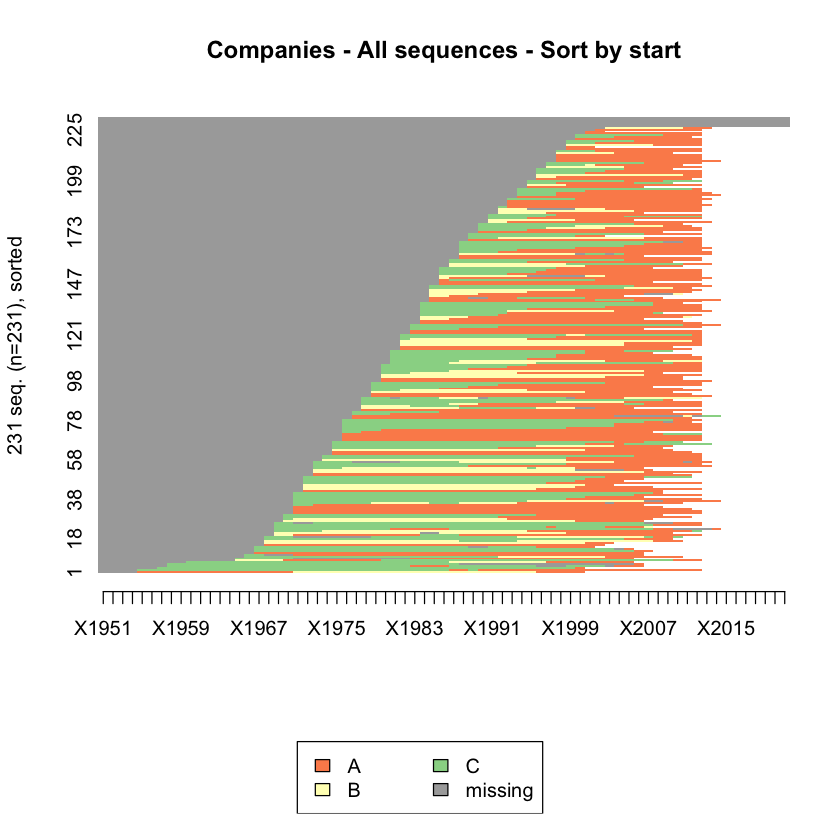

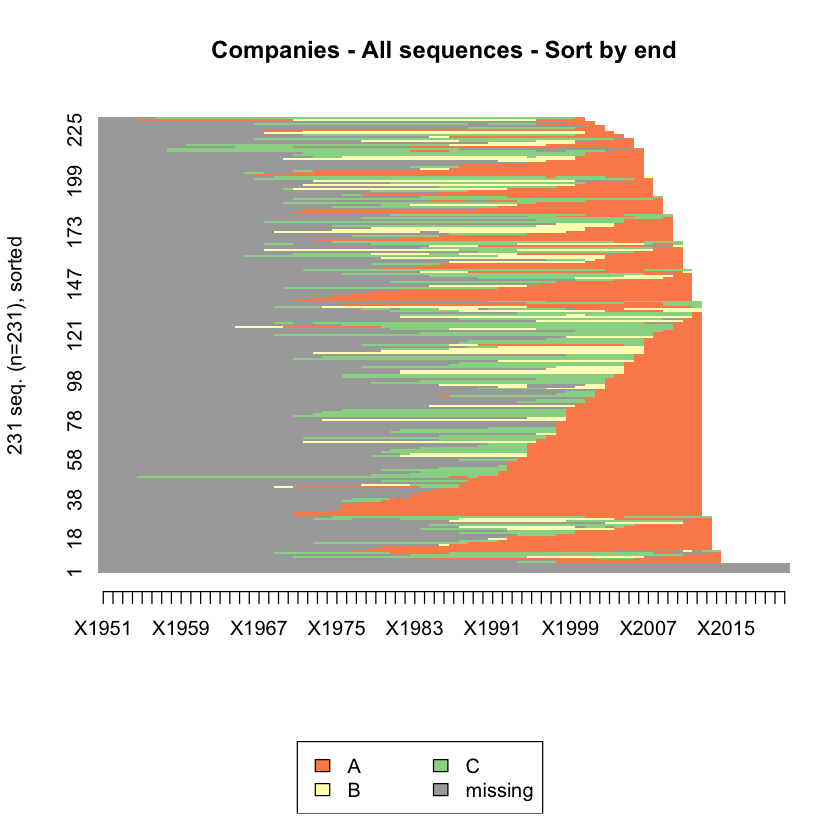

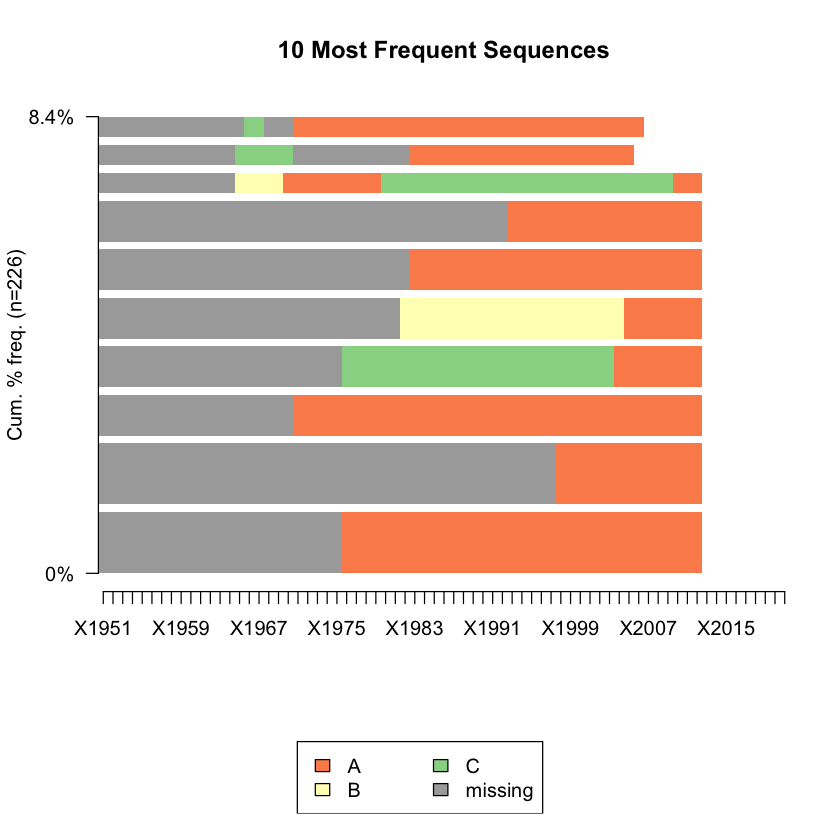

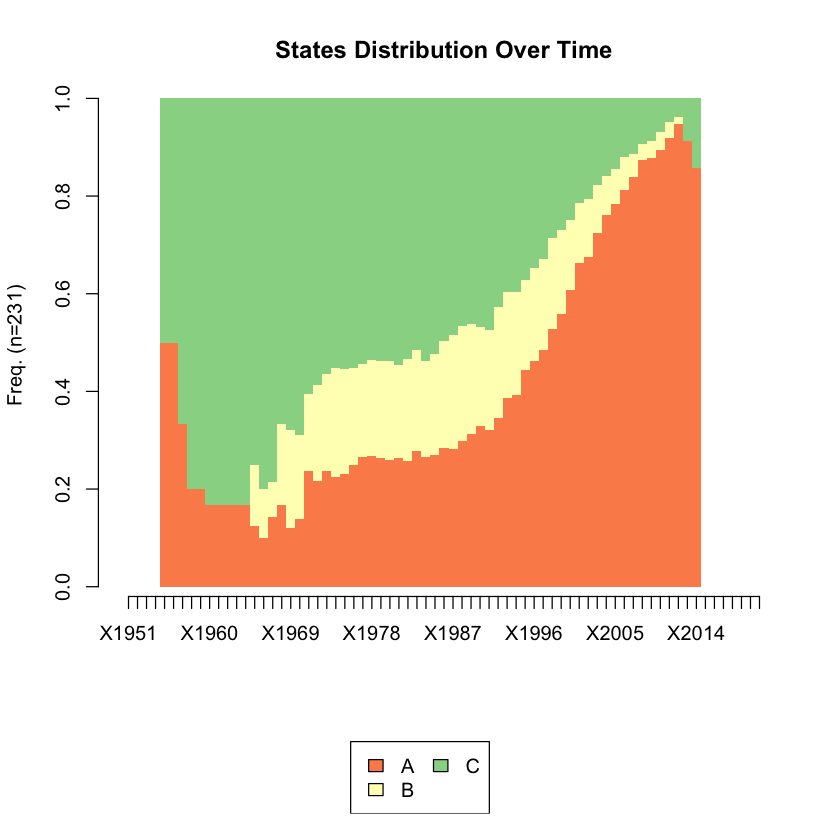

[1] TRUE

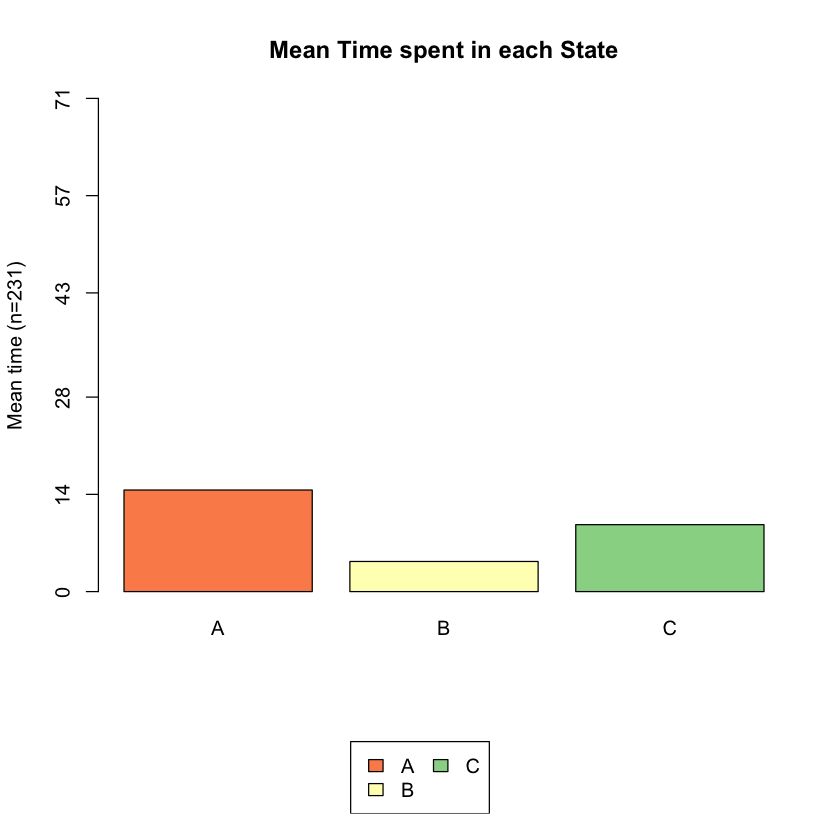

In [6]:
companiesSequence.seq <- seqdef(companiesSequence,NULL,missing="Z")

#This line is just to set the colors to the charts
cpal(companiesSequence.seq) <- brewer.pal(3,"Spectral")

makeSequencePlots(companiesSequence.seq)


### III.1 Distance Calculation and Sequence Analysis

We'll calculate the distance using the ``Optimal Matching`` method, identified by the ``method="OM"`` parameter in the following line of code:

In [7]:
mcdist <- seqdist(seqdata=companiesSequence.seq,method="OM",sm="CONSTANT",with.missing=TRUE)

 [>] setting 2 as substitution cost for missing values
 [>] creating 4x4 substitution-cost matrix using 2 as constant value
 [>] 231 sequences with 3 distinct events/states
 [>] including missing value as additional state
 [>] 218 distinct sequences
 [>] min/max sequence length: 50/71
 [>] computing distances using OM metric
 [>] total time: 0.335 secs


Next, we'll create the clusters using the ``ward`` algorithm and plot its dendogram.

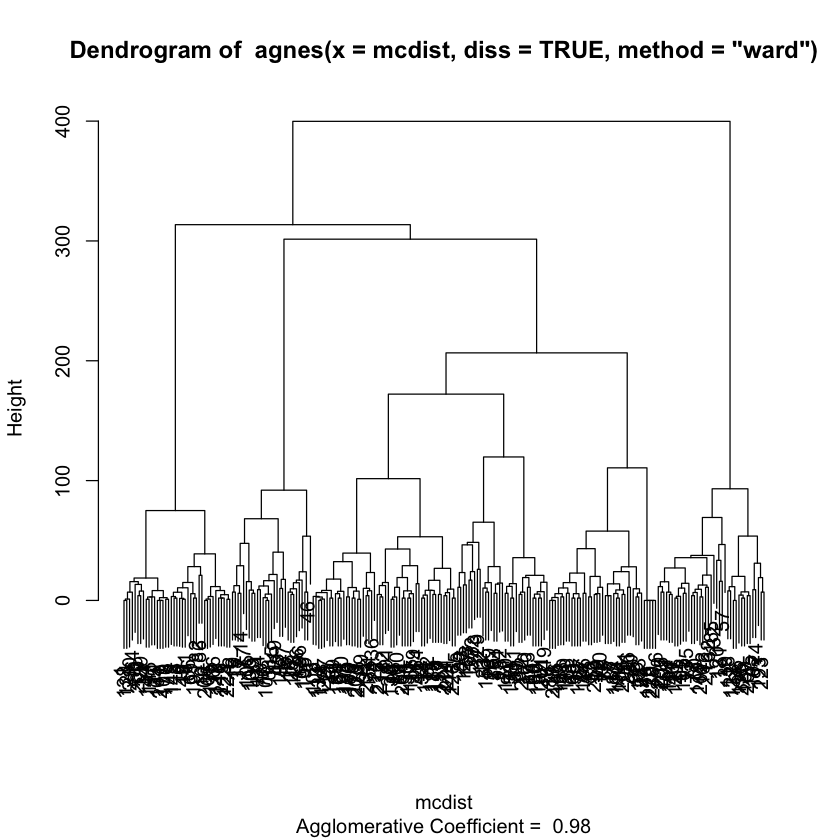

In [8]:
clusterward <- agnes(mcdist,diss=TRUE,method="ward")

plot(clusterward,which.plots=2)

Finally, we will choose how many cuts (or clusters) we want to separate them in. We will use a table to see how manu

NOTE: Remember that, if you've installed jupyter notebooks you can change the number of cuts in the code below !

In [9]:
numberOfCuts <- 4
 
clusters <- cutree(clusterward,k = numberOfCuts)

table(clusters)

clusters
  1   2   3   4 
 39  29 124  39 

Lastly we will plot the clusters and see if one of them looks like the pattern we are looking for, the returning heir.

I've run the analysis for 4, 5, 6 and 7. None of them return any clear indication of the returning heir.

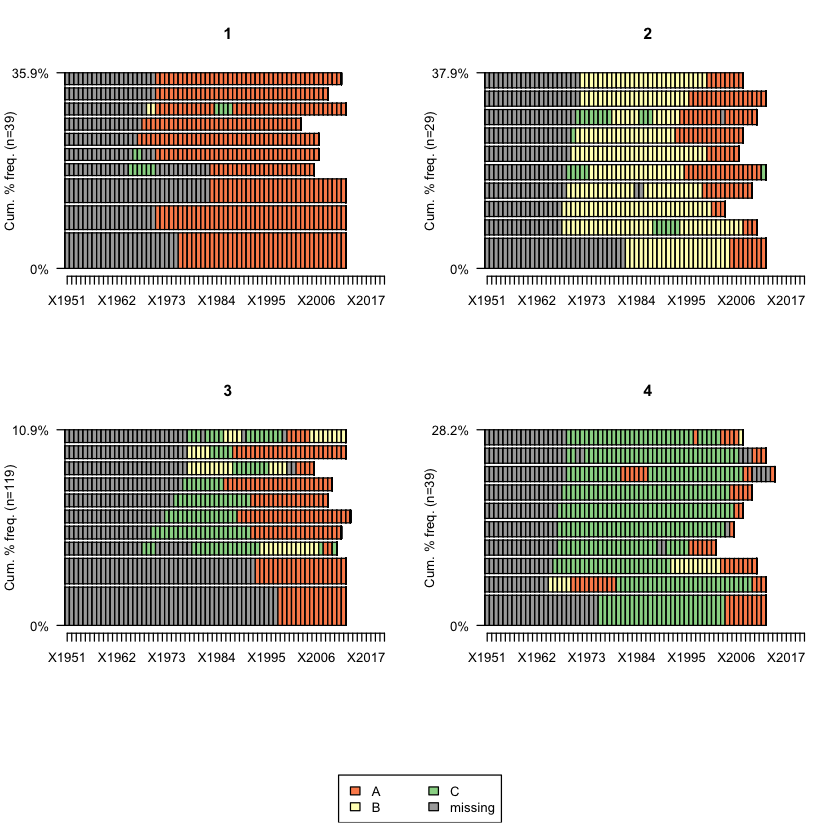

In [10]:
seqfplot(companiesSequence.seq,group=clusters,pbarw=TRUE)

## IV Companies, Single Dimension, Synchoronous

Using the same data we build another sequence. This time the only differente is that all the missing values in the beggining and in the end of the sequence.

This implies that if a given sequence starts say in 1990 this will be considered $$\tau = 1$$

Arguably this approach makes sense, because we are not looking to observer changes in given years, all that matters to us is the path, not when it hapenned.

The options ``right="DEL"`` and ``left="DEL"`` make those deletions.

Again after creating the sequence we generate the plots.

 [>] found missing values ('Z') in sequence data
 [>] preparing 231 sequences
 [>] coding void elements with '%' and missing values with '*'
 [!] sequence with index: 24,44,178,229,230 contains only missing values.
     This may produce inconsistent results.
 [>] state coding:
       [alphabet]  [label]  [long label] 
     1  A           A        A
     2  B           B        B
     3  C           C        C
 [>] 231 sequences in the data set
 [>] min/max sequence length: 2/71


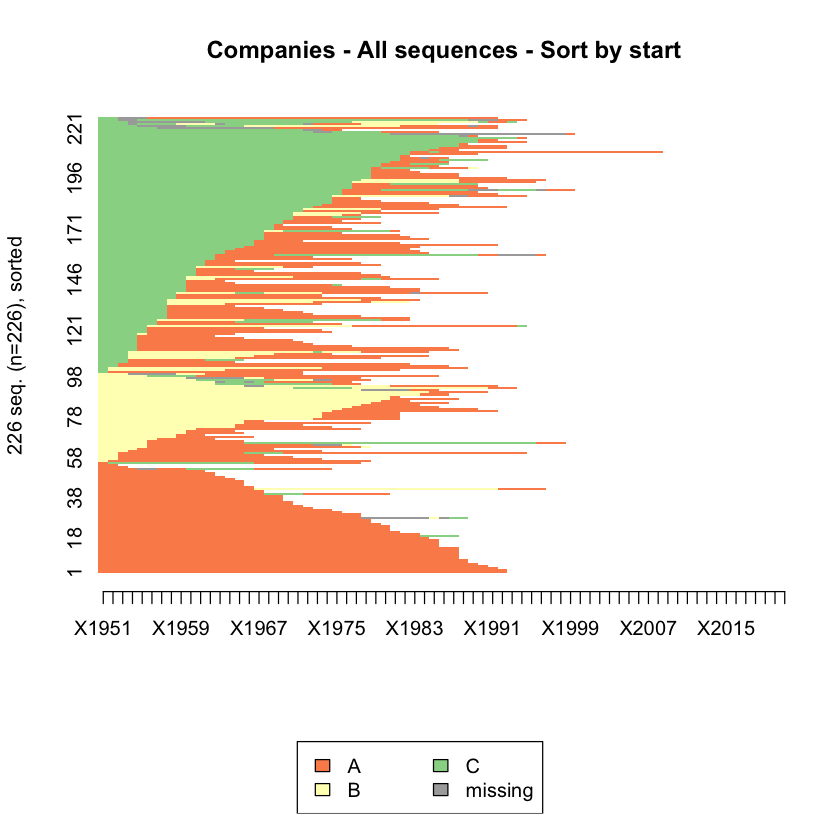

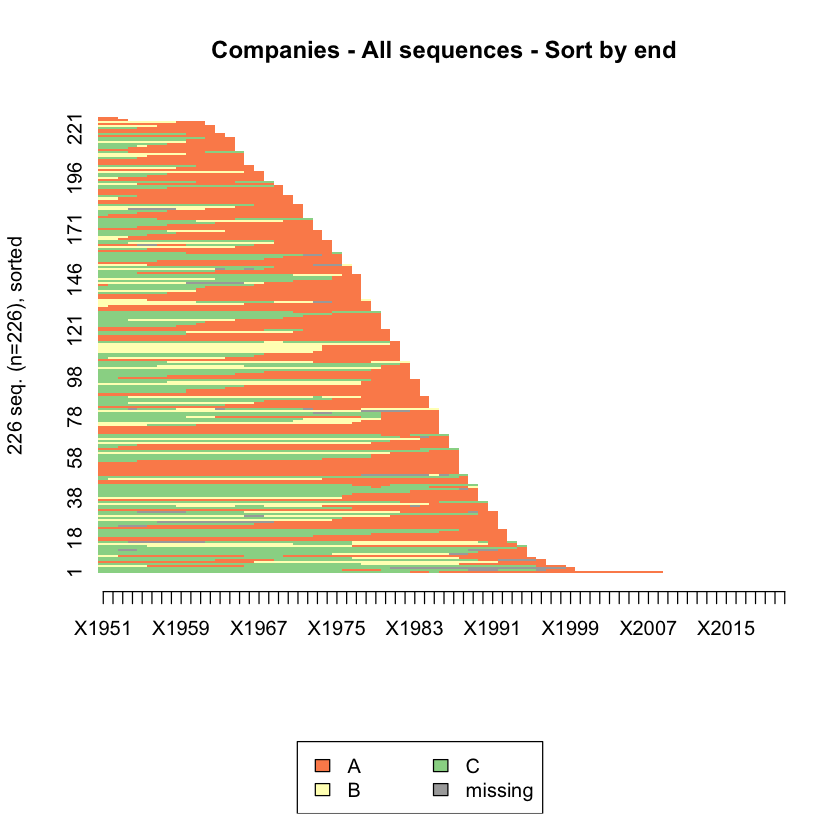

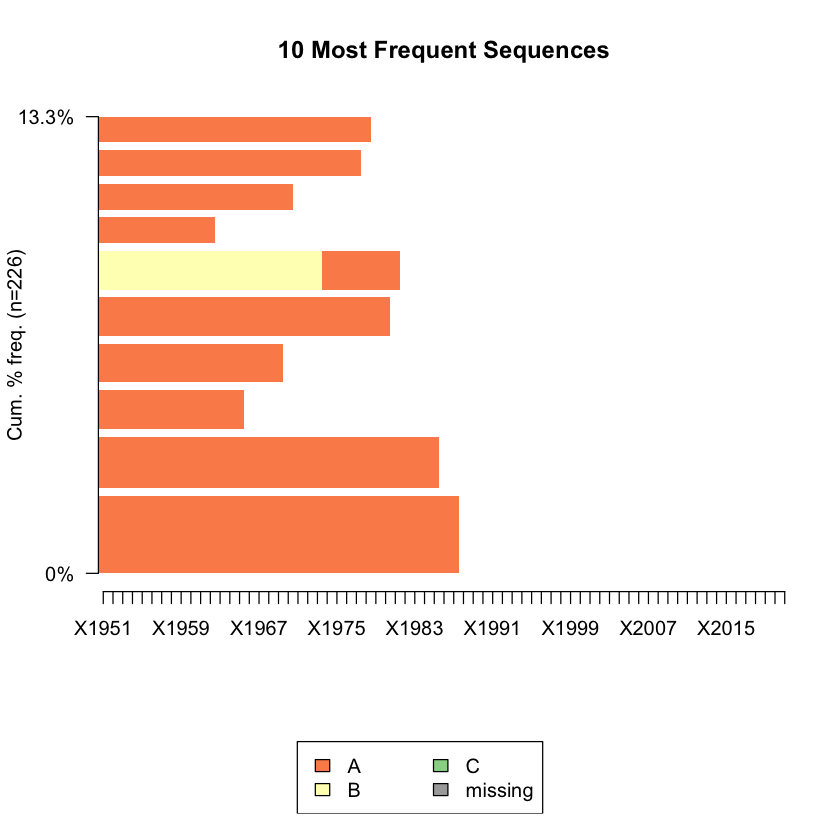

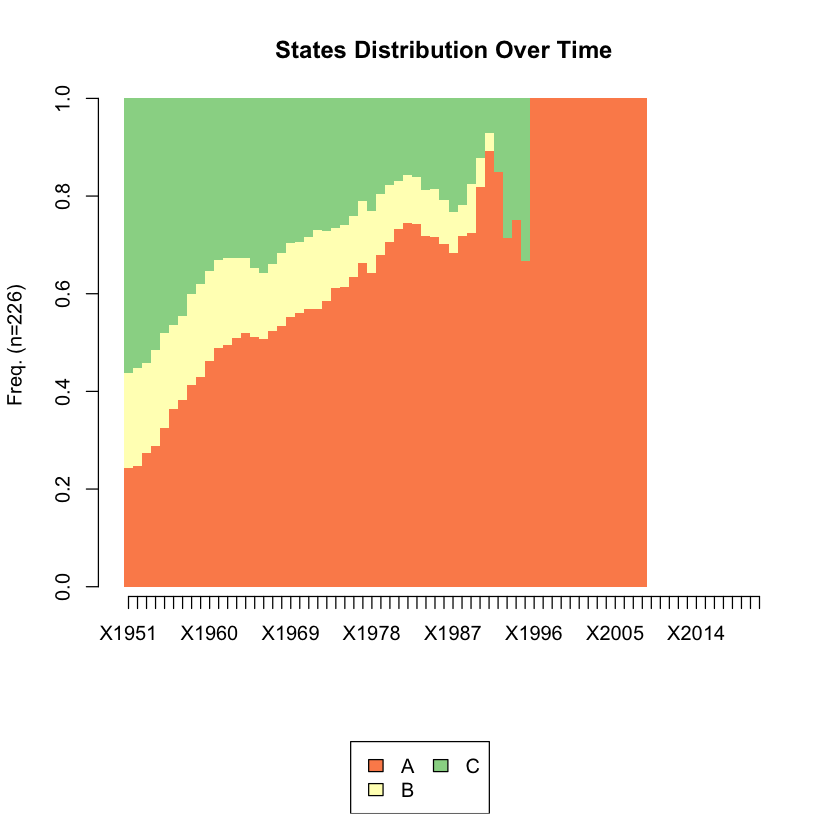

[1] TRUE

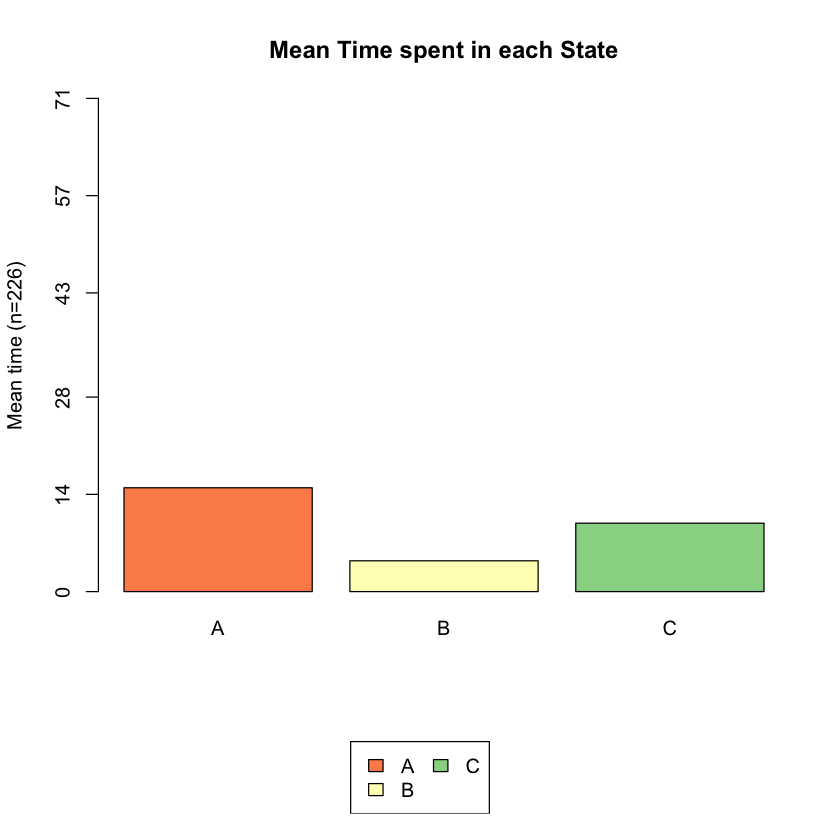

In [11]:
companiesSequence.scodes <- c('A','B','C')
companiesSequence.alphabet <- c('A','B','C')
companiesSequence.labels <- c('A','B','C')
companiesSequence.seq <- seqdef(companiesSequence,NULL,states=companiesSequence.scodes,labels=companiesSequence.labels, alphabet=companiesSequence.alphabet,missing="Z",,right="DEL",left="DEL")


# this line is used to delete the rows that contains only missing values
#if the input used is changed this line HAS to be changed
companiesSequence.seq <- companiesSequence.seq[-c(24,44,178,229,330),]
companiesSequence.seq <- companiesSequence.seq[-226,]


#This line is just to set the colors to the charts
cpal(companiesSequence.seq) <- brewer.pal(3,"Spectral")

makeSequencePlots(companiesSequence.seq) 

### IV.1 Distance Calculation and Sequence Analysis

We'll calculate the distance using the ``Optimal Matching`` method, identified by the ``method="OM"`` parameter in the following line of code:

In [12]:
mcdist <- seqdist(seqdata=companiesSequence.seq,method="OM",sm="CONSTANT",with.missing=TRUE)

 [>] setting 2 as substitution cost for missing values
 [>] creating 4x4 substitution-cost matrix using 2 as constant value
 [>] 226 sequences with 3 distinct events/states
 [>] including missing value as additional state
 [>] 202 distinct sequences
 [>] min/max sequence length: 2/58
 [>] computing distances using OM metric
 [>] total time: 0.276 secs


Next, we'll create the clusters using the ``ward`` algorithm and plot its dendogram.

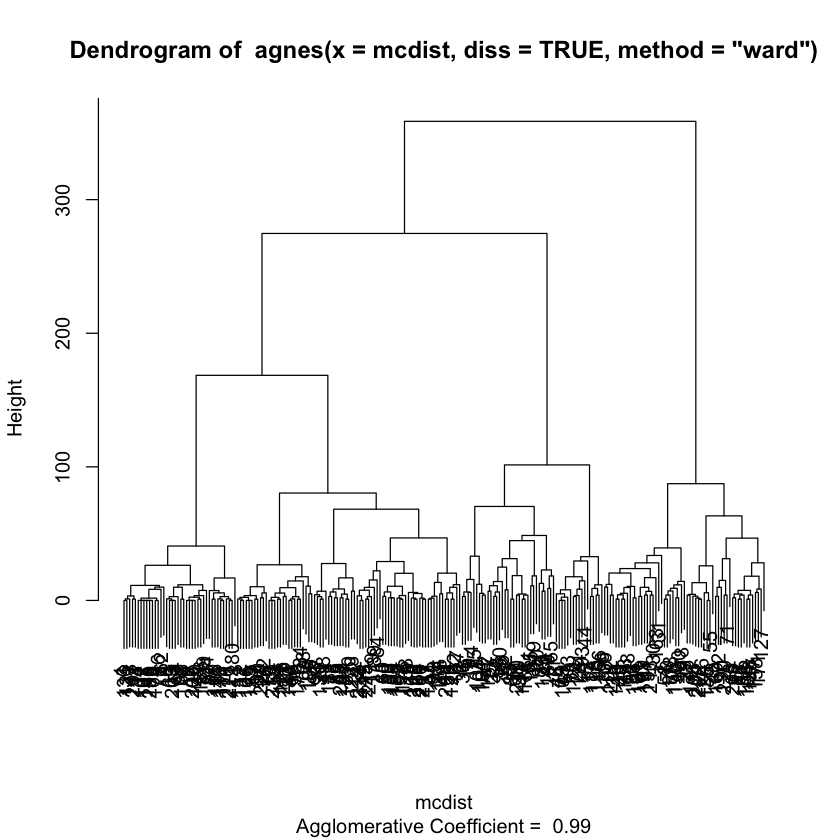

In [13]:
clusterward <- agnes(mcdist,diss=TRUE,method="ward")

plot(clusterward,which.plots=2)

Finally, we will choose how many cuts (or clusters) we want to separate them in. We will use a table to see how manu

NOTE: Remember that, if you've installed jupyter notebooks you can change the number of cuts in the code below !

In [14]:
numberOfCuts <- 5
 
clusters <- cutree(clusterward,k = numberOfCuts)

table(clusters)

clusters
 1  2  3  4  5 
40 33 79 57 17 

Lastly we will plot the clusters and see if one of them looks like the pattern we are looking for, the returning heir.

I've run the analysis for 4, 5, 6 and 7. None of them return any clear indication of the returning heir.

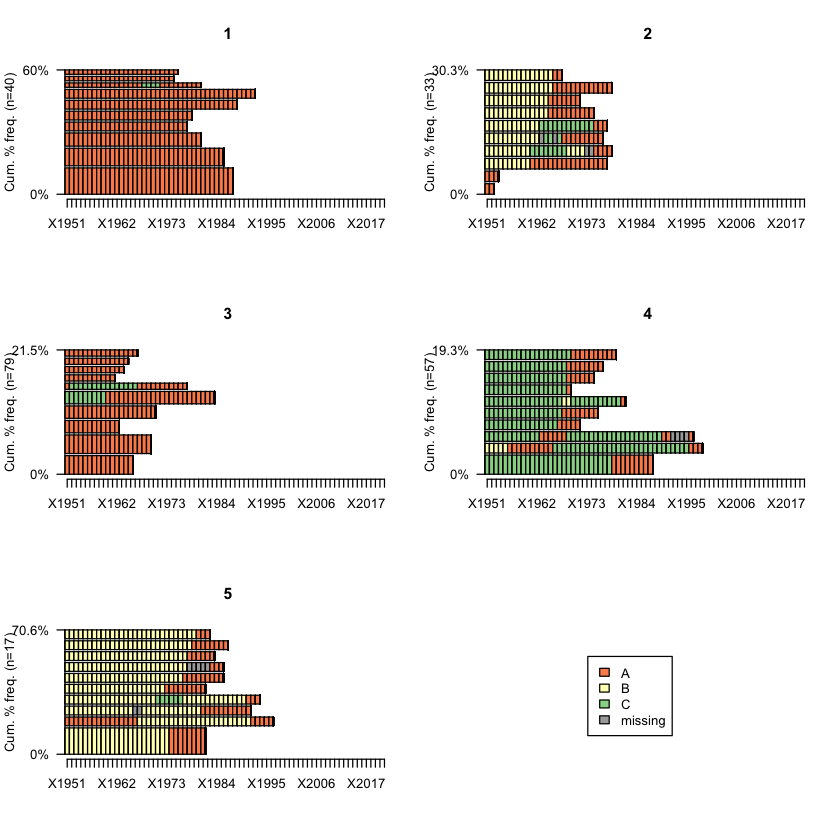

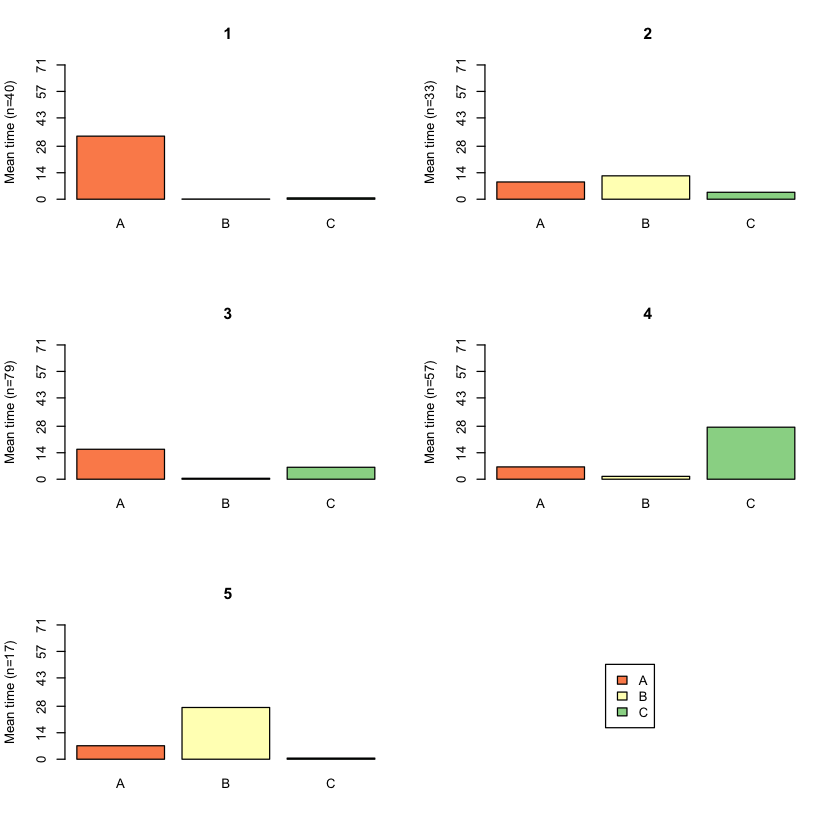

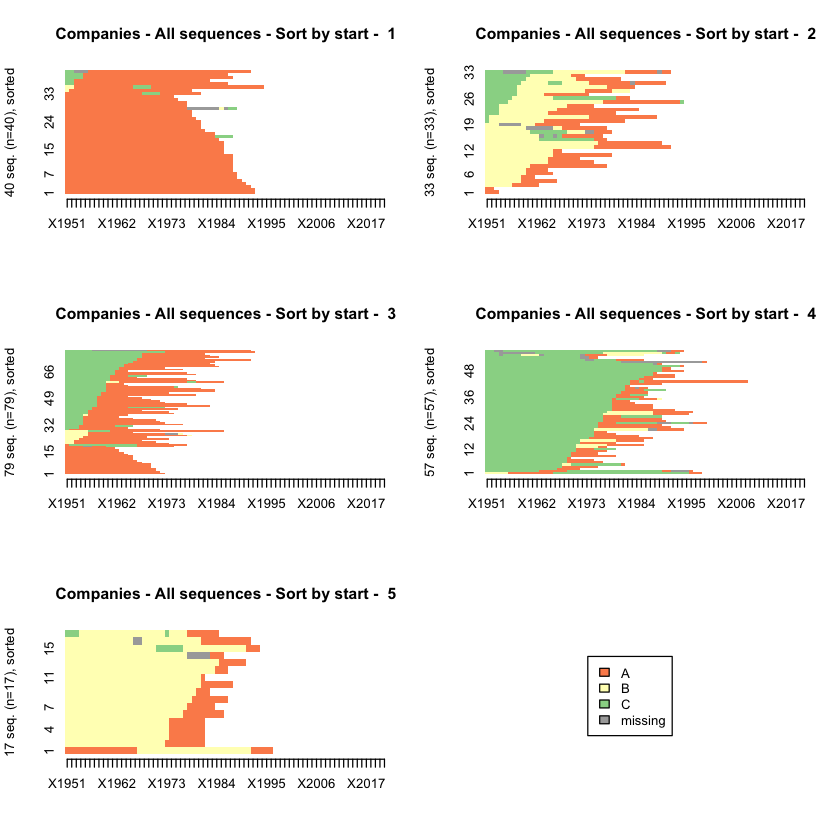

In [15]:
seqfplot(companiesSequence.seq,group=clusters,pbarw=TRUE)
seqmtplot(companiesSequence.seq, group = clusters)
seqIplot(companiesSequence.seq,sortv="from.start",group=clusters,withlegend=TRUE,title="Companies - All sequences - Sort by start")

## V. Check Pattern Ocurrences

In order to check pattern occurrences we first need to create the sequence, then convert it to TraMineR's `TSE` format, and then create a event sequence from that sequence. 


The procedure we use here was described by one of the developers [here](http://stackoverflow.com/questions/28111316/find-specific-patterns-in-sequences)

That is done below:

In [16]:
companiesSequence.seq <- seqdef(companiesSequence,NULL,missing="Z")

 [>] found missing values ('Z') in sequence data
 [>] preparing 231 sequences
 [>] coding void elements with '%' and missing values with '*'
 [!] sequence with index: 24,44,178,229,230 contains only missing values.
     This may produce inconsistent results.
 [>] 3 distinct states appear in the data: 
     1 = A
     2 = B
     3 = C
 [>] state coding:
       [alphabet]  [label]  [long label] 
     1  A           A        A
     2  B           B        B
     3  C           C        C
 [>] 231 sequences in the data set
 [>] min/max sequence length: 50/71


In [17]:
x <-seqformat(companiesSequence.seq,to="TSE",tevent=seqetm(companiesSequence.seq,method="state"))

 [>] input is a sequence object, converting from STS format
 [>] converting special codes for missing states to NA's
 [>] converting 231 sequences to TSE format ...
 [>] STS sequences converted to 236 TSE seq./rows


In [18]:
companiesEventSequence <- seqecreate(x,use.labels=FALSE)

Now in order to check for subsequences, the following procedure is used. It is comprised of creating a subsequence and checking for its ocurrence within every sequence. all the subsequences are written in the first line of code, for example ACA would be "(A)-(C)-(A)".

In [19]:
subs <- seqefsub(companiesEventSequence,strsubseq=c("(A)-(C)-(A)","(B)-(C)-(B)","(A)-(C)-(B)","(B)-(C)-(A)"))
# subs <- seqefsub(companiesEventSequence,strsubseq=c("(A)-(C)-(A)"))
subs.pres <- seqeapplysub(subs,method="presence")
# subs.pres
# numberOfMatches = subs.pres[,1] + subs.pres[,2] + subs.pres[,3] + subs.pres[,4]

Number of Matching sequences:

In [20]:
match = subs.pres[,1] + subs.pres[,2] + subs.pres[,3] + subs.pres[,4]
match = match > 0
sum(match)

[1] 11

Matching Sequences

In [21]:
index <- which(subs.pres[,1]==1)

In [22]:
companies[index,]

,Target.Company.Name,Full.Name,P_ID,Primary.SIC.Code,Dimensions,X1951,X1952,X1953,X1954,X1955,⋯,X2012,X2013,X2014,X2015,X2016,X2017,X2018,X2019,X2020,X2021
235,ALBERTSON'S INC,Lawrence R. Johnston,1240Lawrence R. Johnston,5411,Companies,Z,Z,Z,Z,Z,⋯,Z,Z,Z,Z,Z,Z,Z,Z,Z,Z
265,ALLEGHENY ENERGY INC,Paul J. Evanson,1279Paul J. Evanson,4911,Companies,Z,Z,Z,Z,Z,⋯,Z,Z,Z,Z,Z,Z,Z,Z,Z,Z
565,APOLLO EDUCATION GROUP INC,Gregory W. Cappelli,31122Gregory W. Cappelli,8221,Companies,Z,Z,Z,Z,Z,⋯,A,Z,Z,Z,Z,Z,Z,Z,Z,Z
703,AVIS BUDGET GROUP INC,Ronald L. Nelson,3278Ronald L. Nelson,7514,Companies,Z,Z,Z,Z,Z,⋯,A,Z,Z,Z,Z,Z,Z,Z,Z,Z
781,BARRICK GOLD CORP,Gregory C. Wilkins,2055Gregory C. Wilkins,1041,Companies,Z,Z,Z,Z,Z,⋯,Z,Z,Z,Z,Z,Z,Z,Z,Z,Z
949,BLOCK H & R INC,Alan M. Bennett,2269Alan M. Bennett,7291,Companies,Z,Z,Z,Z,Z,⋯,Z,Z,Z,Z,Z,Z,Z,Z,Z,Z
